<div class="alert alert-block alert-info">
Author:<br>Felix Gonzalez, P.E. <br> Adjunct Instructor, <br> Division of Professional Studies <br> Computer Science and Electrical Engineering <br> University of Maryland Baltimore County <br> fgonzale@umbc.edu
</div>

The objective of this Jupyter Notebook is to introduce the topic of Supervised Machine Learning (ML) Classification in combination with Natural Language Processing (NLP) and further discuss classification of text data.

# Table of Contents
[Data](#Data)

[Data Loading](#Data-Loading)

[Data Balance-Sampling](#Data-Balance-Sampling)

- [Random Under-Sampling](#Random-Under-Sampling)

[Stopwords](#Stopwords)

[Text Normalization Functions](#Text-Normalization-Functions)

[ML Classification Process](#ML-Classification-Process)

[Bag of Words (BoW) Model and Token Vectorization](#Bag-of-Words-(BoW)-Model-and-Token-Vectorization)

- [Classifier Algorithm](#Classifier-Algorithm)

[Predicting Using the Model](#Predicting-Using-the-Model)

[Dimensionality Reduction](#Dimensionality-Reduction)

- [PCA](#PCA)

- [TSNE](#TSNE)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk # Natural Langage Toolkit
from nltk import word_tokenize, pos_tag # Tokenizer and Parts of Speech Tags
from nltk.tokenize import RegexpTokenizer # Tokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer # Lemmitization and Stemming
from nltk.corpus import stopwords, wordnet # Stopwords and POS tags

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer # Vectorization Functions
# Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import r2_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA # used for PCA Dimensionality Reduction
from sklearn.manifold import TSNE # Used for TSNE Dimensionality Reduction.

# Classification Models
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Default Jupyter Notebook Settings
pd.set_option('display.max_colwidth', None) # PD has a limit of 50 characters.  Removes limit and uses the full text.
pd.options.display.float_format = "{:.4f}".format # Sets PD to displays float numbers as 4 decimal places.

# Data
[Return to Table of Contents](#Table-of-Contents)

This notebook was inspired by publicly available dataset from the United States (U.S.) Mining Safety and Health Administration (MSHA) data and work by The U.S. Bureau of Labor Statistics (BLS) and U.S. the Center for Disease Control and Prevention (CDC) National Institute for Occupational Safety and Health (NIOSH) which have been using ML classification algorithms to classify worker injury data in the U.S. industry.

References:
- NIOSH CDC NASA AI MSHA Data Autocoding Competition Github (https://github.com/NASA-Tournament-Lab/CDC-NLP-Occ-Injury-Coding): Solutions use deep learning algorithms to classify the data. 
- BLS Autocoding with Deep Neural Networks (https://www.bls.gov/iif/automated-coding/deep-neural-networks.pdf)
- BLS Alexander Measures Autocoding Github (https://github.com/ameasure/autocoding-class): Solution sses Logistic Regression model to classify the data.
- BLS MSHA Autocoding: https://www.bls.gov/iif/automated-coding.htm
- MSHA Data and Reports: https://www.msha.gov/data-and-reports
- NIOSH AI MSHA Data Autocoding Competition https://archive.cdc.gov/www_cdc_gov/niosh/updates/upd-02-26-20.html

The dataset is a collection of worker injury narrative reports and their classification using the categories of Occupational Injury and Illness Classification System (OIICS). The BLS and NIOSH receive hundred of thousand of worker injury reprots which are then used to calculate industry statistics. In the past, these reprots were coded/classified manually and lent themselves to ML classification algorithms. This notebook will explore how to use ML classification algorithms with the dataset. The references above contain various examples as well as the evolution from how and which supervised ML algorithms have been used over the years. 

The competition consistend on using code unstructured work-related injury narrative reports to classify and code 48 unique OIICS two-digit "event" codes (column titled "event"). Let's explore the data and see how we can use Suprevised ML to make predictions on new text. Note that the functions in this notebook can be easily modified to be used with any dataset as long as there is a categorical value (e.g., class, label, etc.) to predict (i.e., target).

### Data Loading
[Return to Table of Contents](#Table-of-Contents)

In [3]:
df_MSHA = pd.read_csv("./input_data/OIICS_Dataset.csv")

In [4]:
df_MSHA.sample(10)

,id,text,sex,age,event
62215,77968,32 YOM SECURITY GUARD AT A MALL WAS KICKED TWICE IN THE HEAD WHILE TRYING TO APPREHEND A SHOPLIFTER SUSTAINING A CHI,1,32,11
39488,39896,40 YOM DX CORNEAL ABRASION DUE TO DIRECT TRAUMA WOOD HIT EYE AT WORK,1,40,62
78279,120282,31YOF W LUMBAR BACK PAIN S P DRIVER OF BUS IN REAR END MVC YESTERDAY WENT HOME AFTERWARDS REPORTS FELT THE PAIN TODAY,2,31,26
9134,9135,32 YOF DX NEEDLESTICK INJURY S P PT C O NEEDLE STICK TO LT THUMB CONTAMINATED AT WORK TODAY,2,32,55
57501,69618,54YOF RASH TO CHEST AND ARMS WHILE AT WORK FROM UNKNOWN DX ALLERGIC REACTION,2,54,55
11308,11309,27 YOM C O LBP ONSET YESTERDAY WHILE LOADING TRUCK AT WORK DX LBP LUMBAR SPINE STRAIN,1,27,71
42332,43792,31YOF C O PINKY LACERATION THIS AFTERNOON WORK LACERATED SM FINGERDX LAC FINGER,2,31,60
5447,5448,34 YOM CONTUSION TO LOWER BACK REPORTS HUGE ROCK DIRT FROM CONSTRUCTION CAVE FELL ON HIM S P DIGGING IN DITCH WORK W UNPOWERED TOOL,1,34,65
32237,32248,24 YOM C O WHILE AT WRK HIT HEAD ON TOP OF LOCKER DOOR DX BHT,1,24,63
40834,41489,61YOF TRIPPED OVER SCOOTER FELL LANDED ON RT SIDE DX RT SHOULDER KNEE STRAIN WORK,2,61,42


In [5]:
print(df_MSHA.shape)
df_MSHA.info()

(98484, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98484 entries, 0 to 98483
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      98484 non-null  int64 
 1   text    98484 non-null  object
 2   sex     98484 non-null  int64 
 3   age     98484 non-null  int64 
 4   event   98484 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df_MSHA.describe()

,id,sex,age,event
count,98484.0000,98484.0000,98484.0000,98484.0000
mean,72629.7522,1.3343,38.1104,50.9237
std,60563.9143,0.4718,13.1555,20.2414
min,1.0000,1.0000,0.0000,10.0000
25%,24621.7500,1.0000,27.0000,41.0000
50%,55692.5000,1.0000,36.0000,60.0000
75%,103180.7500,2.0000,48.0000,66.0000
max,229810.0000,2.0000,93.0000,99.0000


In [7]:
df_MSHA.describe(include = 'object')

,text
count,98484
unique,98319
top,14YOM EXPOSED TO TOXIC SPRAY WHILE DETASSELING DX EXPOSURE TO TOXIC CHEMICALS NO INJURIES
freq,9


In [8]:
# Before normalizing text, let's evaluate how many categories witin target. 
df_MSHA['event'].value_counts()

event
73    7106
55    7046
62    6792
60    6732
64    6540
71    6166
53    5817
63    5226
13    4861
11    4785
42    4351
43    4292
66    4289
70    4092
26    4017
12    3338
41    2257
24    1517
31    1347
78    1326
27    1260
72    1141
51     741
52     708
44     556
32     494
23     423
99     342
25     146
69     144
67      90
61      78
22      76
40      76
65      73
21      55
49      40
50      39
45      22
20      19
79      18
54      15
56       9
59       7
74       7
10       4
29       2
30       2
Name: count, dtype: int64

Note that some of the event codes above only have just a few samples. Event code 29 only has 2 records. If we were to use this for ML classification algorithm there would only be one way to split the data into training and testing. This would most probably not provide enough data to develop a reliable predictive model. If we needed to use these codes we would have to get more data. There a few ways we could proceed.
- Use the data as is without modifying with the acknowledgement that these Event codes with low numbers will probably not be reliable.
- Filter out the data for these codes and not use them for prediction until we have more data. For example, we could use a threshold, select all records that have an Event code that has at least 50 samples. If you keep the records with small number of samples, during the train/test split you may not get enough data to perform metrics calculation for that specific class and may get a warning or error.
- Manually divide the data especially for those that have small number of values with the acknowledgement that there is not enough data and model may not perform well in this classes.
- Use some of method to address:
    - Obtain more data representative of these codes.
    - Undersampling/oversampling: Most probably will not be able to address the challenge of these codes that have low number of datapoints.
    - Use some other method to address class imbalance.

In [9]:
# This dataframe provides the OIICS Event Codes and their descriptions.
df_OIICS_Event_Code_Map = pd.read_excel("./input_data/OIICS_Event_Code_Map.xlsx")
df_OIICS_Event_Code_Map

,OIICS_Event_Code,OIICS_Event_Description
0,10,"Violence and other injuries by persons or animals, unspecified"
1,11,Intentional injury by person View descriptive information for code item
2,12,Injury by person—unintentional or intent unknown
3,13,Animal and insect related incidents View descriptive information for code item
4,20,"Transportation incident, unspecified"
5,21,Aircraft incidents
6,22,Rail vehicle incidents
7,23,Animal and other non-motorized vehicle transportation incidents
8,24,Pedestrian vehicular incident
9,25,Water vehicle incidents


There may be event codes not represented in the sample data. For example, Code "57-Exposure to traumatic or stressful event, n.e.c." does not have any events in the sample data.

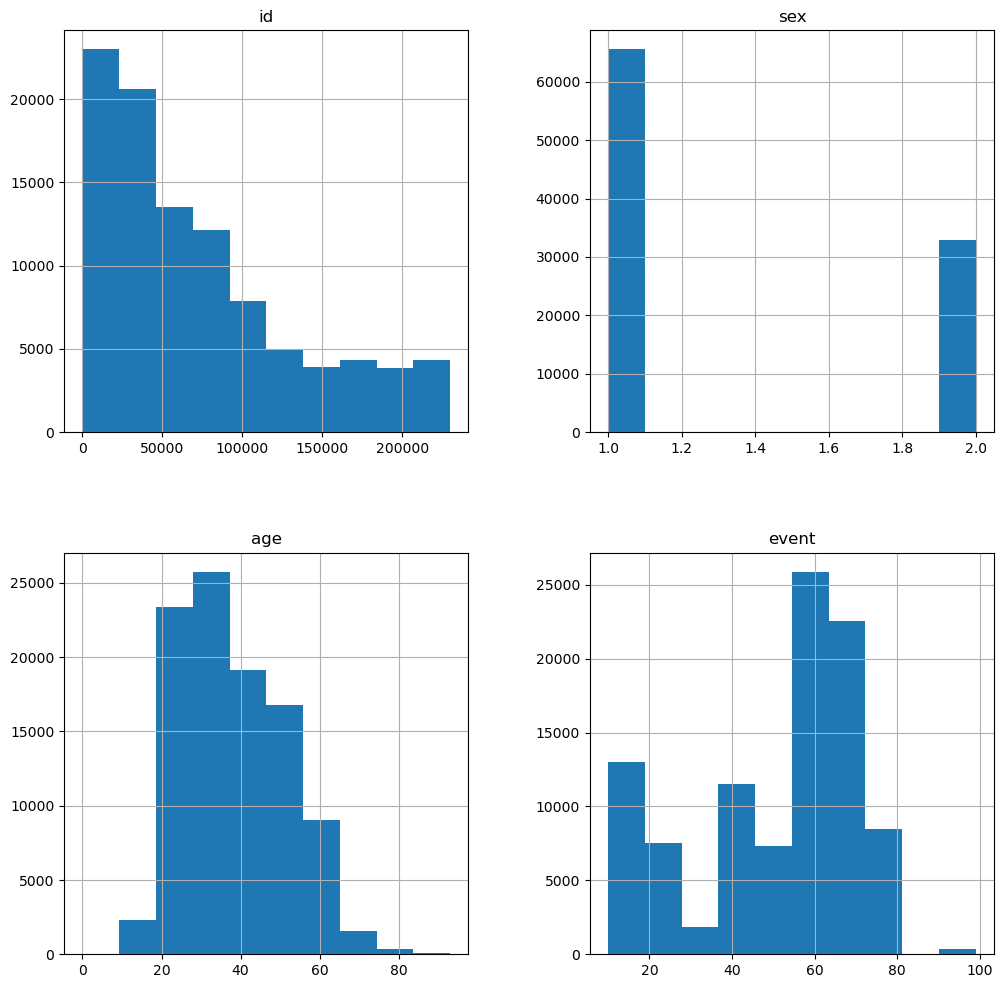

In [10]:
df_MSHA.hist(figsize = [12, 12]);

__A few observations__
- ID's are unique values.
- Event and Sex are categorical values.
- Event seem to have a good majority in the 60 (i.e., contact with object) and 70 (i.e., overexertion) type of events. 

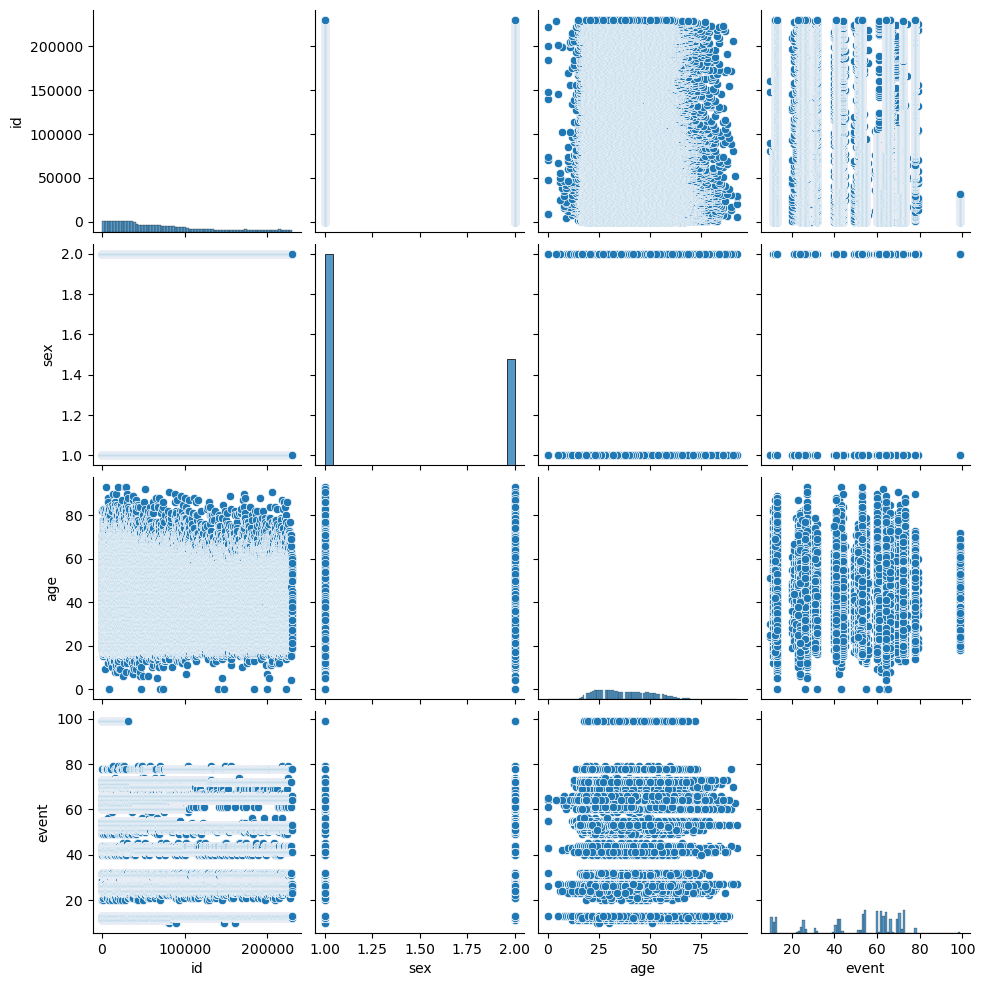

In [11]:
sns.pairplot(df_MSHA);

__A few observations__
- There seem to be ages of 0. Potentially an error.
- Ages less than 18 years would most probably not be legal. Potentially an error.

If age was important may have been worthwhile to address (i.e., remove) or further investigate.

# Data Balance-Sampling
[Return to Table of Contents](#Table-of-Contents)

Data balance or imbalanced data, may be addressed using various approaches or methods. In our dataset, the full dataset has ~230K records for whcih some classes have less than 50 samples. Some approaches that can be utilized to address data balance issues include: 
- Under-sampling (Random or not): Reduces the number of records or samples that are over-represented.
- Over-sampling (Random or not): Increases the number of records or samples that are under-represented. One common approach is "Synthetic Minority Over-sampling Technique (SMOTE)".

Note that these methods are not perfect and by design may loose information or create synthetic information that may cause other issues and the best approach, if possible, would be to obtain or collect more data for under-represented classes.

References:
- https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

### Random Under-Sampling
[Return to Table of Contents](#Table-of-Contents)

In random under sampling, a smaller dataset is created where the majority class is under sampled using a threshold of records. For example, in this case we will select 1000 records for those categories that have more than 1000 and for those that have less we will select the full dataset. This approach will also ignor classes that have less than 50 records at the cost of losing those classes. This will result in a smaller dataset that will process faster but still produce good results and resolve some of the issues related to data balance. 

This will reduce the dataset from almost 230K records to almost 29K records.

In [12]:
# Random sample for classes that have 1000 or more and keeps all that have less than 1000.
df_sample = df_MSHA.groupby("event").apply(lambda s: s.sample(min(len(s), 1000))).copy().reset_index(drop = True)
# Filters out classes that have less than 50 records.
df_sample = df_sample.groupby("event").filter(lambda x: len(x) > 50).reset_index(drop = True)

df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26002 entries, 0 to 26001
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      26002 non-null  int64 
 1   text    26002 non-null  object
 2   sex     26002 non-null  int64 
 3   age     26002 non-null  int64 
 4   event   26002 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1015.8+ KB


C:\Users\felix\AppData\Local\Temp\ipykernel_25724\380705983.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_MSHA.groupby("event").apply(lambda s: s.sample(min(len(s), 1000))).copy().reset_index(drop = True)


__Potential Sampling Alternative Approach__
This approach uses the sample does not uses the lambda function. Creates a random sample for classes that have "n" or more but creates duplicate sampels for classes that have less than "n". If the "Replace" parameter = False, it will give an error as there are not enough records to sample from in some cases. If the "Replace" parameter = True it will oversample by creating duplicates of records for categories that have less than the defined "n".

In [13]:
#df_sample = df_MSHA.groupby("event").sample(n=1000, replace = True, random_state=1).copy()

In [14]:
df_sample['event'].value_counts()

event
11    1000
62    1000
60    1000
55    1000
53    1000
12    1000
64    1000
43    1000
42    1000
41    1000
66    1000
70    1000
31    1000
27    1000
26    1000
71    1000
24    1000
72    1000
73    1000
78    1000
13    1000
63    1000
51     741
52     708
44     556
32     494
23     423
99     342
25     146
69     144
67      90
61      78
40      76
22      76
65      73
21      55
Name: count, dtype: int64

# Stopwords
[Return to Table of Contents](#Table-of-Contents)

Stop words are defined as words that occur too often in the corpus and do not have significant contribution to the model, providing insights, or extracting meaning. In a language these can include words that occur too often. NLP libraries (e.g., NLTK, Scikit-learn) typically have a list of predefined stop words. NLP tools can use a list of global stop words applied during text cleaning tasks as well as could also allow users submit custom list of stop words that may be industry specific. The use of stop words (custom or otherwise) need to be documented as removing important words to the corpus may either introduce errors, biases, or give the appearance of bias.

In [15]:
# STOPWORDS USED FOR SAFETY OCCURRENCE CORPUS.
# Stopwords to add need to be evaluated by a SME familiar with the corpus.
stopwords_to_add = [''] # Example: ['building', 'employee','worker']

stopwords_custom = stopwords.words('english') + [x.lower() for x in stopwords_to_add]
#print(stopwords_custom) # Comment out to see list of stopwords_custom before removing the 'no'.

# In some cases you want to consider 2-grams especially with the word no.
# For example 'no fire'.  Removing the word no from the stopwords list allows this to occur.
remove_as_stopword = ['no', 'not']
stopwords_custom = list(filter(lambda w: w not in remove_as_stopword, stopwords_custom))
#print(stopwords_custom)

In [16]:
# The stopword list for NLTK and SciKit learn vary.
# Recommended to review them to make sure there are no unintended consequences.
# Note that stopwords can also be called in the SciKit learn vectorization functions (e.g., TFIDFvectorizer)
# This can cause to inadvertently apply stopwords there as well.

# Text Normalization Functions
[Return to Table of Contents](#Table-of-Contents)

NLP steps are explained in more detail under the Jupyter Notebook "31_Natural_Language_Processing_Introduction.ipynb".

During text normalization various task can be performed which include but not limited to applying lower case, removing numbers and special characters, removing stop words, and applying lemmatization and/or stemming both which reduces words to their root. 

Documentation:
- NLTK Library: https://www.nltk.org/
- NLTK WordnetLemmatizer: https://www.nltk.org/_modules/nltk/stem/wordnet.html
- NLTK Porterstemmer: https://www.nltk.org/howto/stem.html

In [17]:
# Normalization of text. 
def text_normalization(text, word_reduction_method):
    text = str(text) # Convert narrative to string.
    df = pd.DataFrame({'': [text]}) # Converts narrative to a dataframe format use replace functions.
    df[''] = df[''].str.lower() # Covert narrative to lower case.
    df[''] = df[''].str.replace(r"\d+", " ", regex = True) # Remove numbers
    df[''] = df[''].str.replace(r"[^\w\s]", " ", regex = True) # Remove special characters
    df[''] = df[''].str.replace(r"_", " ", regex = True) # Remove underscores characters
    df[''] = df[''].str.replace(r'\s+', ' ', regex = True) # Replace multiple spaces with single
    text = str(df[0:1]) # Extracts narrative from dataframe.
    tokenizer = RegexpTokenizer(r'\w+') # Tokenizer.
    tokens = tokenizer.tokenize(text) # Tokenize words.
    filtered_words = [w for w in tokens if len(w) > 1 if not w in stopwords_custom] # Note remove words of 1 letter only. Can increase to higher value as needed.
    if word_reduction_method == 'Lemmatization':
        lemmatizer = WordNetLemmatizer()
        reduced_words=[lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in filtered_words] # Lemmatization.  The second argument is the POS tag.
    if word_reduction_method == 'Stemming':
        stemmer = PorterStemmer() # Stemming also could make the word unreadable but is faster than lemmatization.
        reduced_words=[stemmer.stem(w) for w in filtered_words]
    return " ".join(reduced_words) # Join words with space.

def get_wordnet_pos(word): # Reference: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#wordnetlemmatizer
    #"""Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

Processing of the text normalization takes about 3 minutes for lemmatization and 40 seconds for stemming. Will increase proportinally if we add more records.

In [18]:
%%time
# Applies the normalization fuction to normalize the question column of the dataset WITHOUT stemming.
df_sample['norm_text_wlemma'] = df_sample['text'].apply(text_normalization, 
                                                        word_reduction_method = 'Lemmatization')

CPU times: total: 2min 3s
Wall time: 2min 5s


In [19]:
df_sample.sample(1) # With norm_text_wlemma column added

,id,text,sex,age,event,norm_text_wlemma
151,26646,28 YOF LACERATION TO LT ANKLE W ABRASION TO UPPER BACK LT FACE S PA PT WORK BECAME VIOLET ASSAULTED HER 7 WKS PREGNANT,2,28,11,yof laceration lt ankle abrasion upper back lt face pa pt work become violet assault wks pregnant


In [20]:
%%time
# Applies the normalization fuction to normalize the question column of the dataset WITH stemming.
df_sample['norm_text_wstemming'] = df_sample['text'].apply(text_normalization, 
                                                           word_reduction_method = 'Stemming')

CPU times: total: 33.8 s
Wall time: 34.4 s


In [21]:
df_sample.sample(1) # With norm_text_wstemming column added.

,id,text,sex,age,event,norm_text_wlemma,norm_text_wstemming
9517,2128,37 YEAR OLD MALE PATIENT FELL 3 DAYS AGO AT WORK DX SPRAIN TO RIGHTSHOULDER,1,37,42,year old male patient fell day ago work dx sprain rightshoulder,year old male patient fell day ago work dx sprain rightshould


Note that sometimes when normalizing text data, all the words on the text record being normalized can be removed (e.g., if all the words are stop words). This may result in issues when calculating the BoW models token vectors. We need to evaluate the issue and when it cannot be resolved we need to filter out these rows.

In [22]:
print(f'Number of null values in the norm_text_wlemma:')
print(df_sample['norm_text_wlemma'].isnull().sum()) # Checks number of rows with null values on norm_text_wlemma column
print(df_sample[df_sample['norm_text_wlemma'] == ''].shape[0]) # Check number of rows with blank strings on norm_text_wlemma column 

print(f'Number of null values in the norm_text_wstemming:')
print(df_sample['norm_text_wstemming'].isnull().sum()) # Checks number of rows with null values on norm_text_wstemming column
print(df_sample[df_sample['norm_text_wstemming'] == ''].shape[0]) # Check number of rows with blank strings on norm_text_wstemming column 

Number of null values in the norm_text_wlemma:
0
0
Number of null values in the norm_text_wstemming:
0
0


The cell below allows us to explore the rows that have blank columns in the norm_text columns. In this case we can see that the question seems to have an error and not complete. We need to filter out these rows. Looks like there were no cases where the cell was empty.

In [23]:
#df[df['norm_text_wstemming'].isnull].head()
df_sample[df_sample['norm_text_wstemming'] == ''].head()

,id,text,sex,age,event,norm_text_wlemma,norm_text_wstemming


In [24]:
# Drops rows with null and blank norm_text columns and resets index.
# These rows with a blank normalized text are not usefule for ML classification.

print(df_sample.shape)
df_sample = df_sample[df_sample['norm_text_wlemma'].notnull()].reset_index(drop=True)
df_sample = df_sample[df_sample['norm_text_wlemma'] != ''].reset_index(drop=True)
df_sample = df_sample[df_sample['norm_text_wstemming'].notnull()].reset_index(drop=True)
df_sample = df_sample[df_sample['norm_text_wstemming'] != ''].reset_index(drop=True)
print(df_sample.shape)

(26002, 7)
(26002, 7)


In [25]:
# Let's exprot this dataframe which we will use in other examples.
df_sample.to_csv(r'.\output_data\df_sample_norm_text.csv', encoding='utf-8-sig', 
                 index = False, 
                 header = True)

# ML Classification Process
[Return to Table of Contents](#Table-of-Contents)

Recall from our lecture 11 (i.e., Jupyter Notebook 25_Supervised_ML_Classification.ipynb) the steps to use ML classification which includes the following steps:
- Defining values of the independent variable or variables (x)
- Defining values of the dependent variable or variable to be predicted (y)
- Scaling/normalization if needed
- Train/Test Split (Typically 80/20)
- Fitting the training data to the model
- Calculate predictions using the testing data 
- Calculating model performance metrics: For classification model common metrics are confusion matrix, null-accuracy, sensitivity, specificity, precision, recall, f-measure, true-positive rate, false-positvie rate, etc.)
- Deploy and use the model for predicting. 

In [26]:
# Dividing the sampled data into 80 for Training and 20 for testing.

x = df_sample.loc[:,'norm_text_wlemma'] # The features we want to use for predicting is the tokens from the narratives.
y = df_sample.loc[:,'event']

X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    stratify = y, # Stratified sampling attempts to balance classes.
                                                    test_size=0.2, # 80/20 for training/testing
                                                    random_state=1)

Stratified sampling tries to balance the training data and maintain the relative class  frequencies is approximately preserved in each train and validation fold.

# Bag of Words (BoW) Model and Token Vectorization
[Return to Table of Contents](#Table-of-Contents)

In [27]:
# Creating BOW for the Target DataFrame with selected Vectorizer TFIDF
# Note that CountVectorizer is another vectorization function.
# The below function defines an instance of the vectorizer with its specific parameters.
vectorizer = TfidfVectorizer(lowercase=True, 
                             analyzer='word',
                             stop_words=stopwords_custom, 
                             # Ensures I am applying the same stopwords here and in text normalization function.
                             ngram_range=(1, 2), # Considers 1-grams (i.e., single words) and 2-grams (i.e., two words) 
                             max_df = 0.95, 
                             min_df = 0.0005)

The classification algorithm can be applied to the vectorization of different texts. In this notebook we have creater/divided a version of the text that is lemmatized and another version that is stemmed. As a data scientist you will need to decide what word reduction method (if any) works best for your application. Note that there may be many different approaches to develop a model. The BLS and NIOSH references above provide examples of different ways to solve the same problem. 

If we were to filter data (we only want specific categories) we would filter before this step (Remember to reset index after filtering data). 

It is important to note that NLP are high dimensional problems where each token is a dimension. In many cases it is recommended to use dimensionalit reduction methods. See more on the Dimensionality Reduction Section.

In [28]:
# Converts the training data to a Bag of Words Array
X_train = vectorizer.fit_transform(X_train).toarray()

In [29]:
print(len(X_train[0]))
X_train

4130


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
# Returns word vectors.
features = vectorizer.get_feature_names_out()
print(f'Number of tokens in the Bag of Words Model: {len(features)}')
features

Number of tokens in the Bag of Words Model: 4130


array(['ab', 'ab deployed', 'ab dx', ..., 'yr', 'ytd', 'ytd work'],
      dtype=object)

In [31]:
# Combining the bow_array with the tokens.
# Note that the total number of ccolumns is the number of tokens or dimensions we have.
# Note that there are some 1-grams (token composed of 1 word) and 2-grams (token composed of 2 words).
df_bow = pd.DataFrame(X_train, columns = features)
print(df_bow.shape)
df_bow.sample(10)

(20801, 4130)


,ab,ab deployed,ab dx,abd,abd pain,abd wall,abdomen,abdominal,abdominal pain,able,...,yom wrist,yowf,yowf wk,yowf work,yowm,yowm wk,yowm work,yr,ytd,ytd work
4479,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7544,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4835,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2772,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
15170,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
12589,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
12195,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9826,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
16205,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


The matrix created is called a [sparse matrix](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html). Exploring the statistics using the describe function allows us to see that the numbers are not 0 and explore some of the values. Each column in the matrix represents a vector for each dimension (e.g., token).

In [32]:
df_bow.describe()

,ab,ab deployed,ab dx,abd,abd pain,abd wall,abdomen,abdominal,abdominal pain,able,...,yom wrist,yowf,yowf wk,yowf work,yowm,yowm wk,yowm work,yr,ytd,ytd work
count,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,...,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000,20801.0000
mean,0.0014,0.0004,0.0002,0.0018,0.0005,0.0002,0.0012,0.0009,0.0005,0.0002,...,0.0007,0.0008,0.0002,0.0002,0.0014,0.0004,0.0004,0.0003,0.0007,0.0002
std,0.0192,0.0100,0.0087,0.0252,0.0141,0.0075,0.0219,0.0185,0.0136,0.0086,...,0.0150,0.0158,0.0081,0.0081,0.0189,0.0106,0.0116,0.0101,0.0153,0.0085
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,0.4412,0.2883,0.4109,0.7160,0.5587,0.3883,0.7330,0.5801,0.6413,0.4067,...,0.5097,0.4697,0.3950,0.4309,0.4195,0.3408,0.5116,0.3828,0.5590,0.4470


In [33]:
# Converts the testing data to the BoW Array of the Training data
X_test = vectorizer.transform(X_test).toarray()

__IMPORTANT NOTE__
If you erroneously apply the ".fit_transform" you may get an error in later parts of the process. fit_transform will recalculate new tokens and BoW matrix based on the test data and cause Train and Test data BoW matrices to have different shapes. The Transform creates the vectors for the Testing data based on the vectors of the Training data.

In [34]:
print(len(X_test[0]))
X_test

4130


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Classifier Algorithm
[Return to Table of Contents](#Table-of-Contents)

Logistic Regression, Support Vector Machines (SVM), Naive-Bayes and Random Forests classifiers are provided below for testing the performance. Only need to uncommend the classifier (clf) to be used. 

Documentation References:
- https://scikit-learn.org/stable/modules/svm.html  

__Multi-Class Classification metrics__ 
Vary from those of binary classification and have to make adjustments in the parameters when of each of the metric evaluation functions. 

- https://scikit-learn.org/stable/modules/model_evaluation.html 

__Confusion Matrix__
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay

In [35]:
%%time
# Classifier (clf) Algorithms
clf = RandomForestClassifier(max_depth = None,  class_weight = 'balanced', random_state=0) 
#clf = LogisticRegression(C=0.1, solver = 'liblinear', multi_class = 'auto', class_weight = 'balanced', random_state=0) 
#clf = MultinomialNB() 
#clf = svm.SVC(C = 1.0, class_weight = 'balanced', break_ties = True)

# SVM takes 40+ minutes to train/fit. Random Forest takes about 1 minute.
clf.fit(X_train, y_train)

CPU times: total: 40.4 s
Wall time: 41.2 s


RandomForestClassifier(class_weight='balanced', random_state=0)

In [36]:
%%time
# When using SVM classifier it may 20+ minutes to calculate predictions. 
y_predict = clf.predict(X_test)

cm = confusion_matrix(y_test, y_predict)
print('Confusion Matrix : \n', cm)
total1=sum(sum(cm))

Confusion Matrix : 
 [[129  27   4 ...   2   0   1]
 [ 25  89   9 ...   3   0   1]
 [  3   2 163 ...   0   1   0]
 ...
 [  1   5   1 ... 108   8   3]
 [  0   1   0 ...  19 120   1]
 [  0   1   1 ...   6   0  15]]
CPU times: total: 844 ms
Wall time: 887 ms


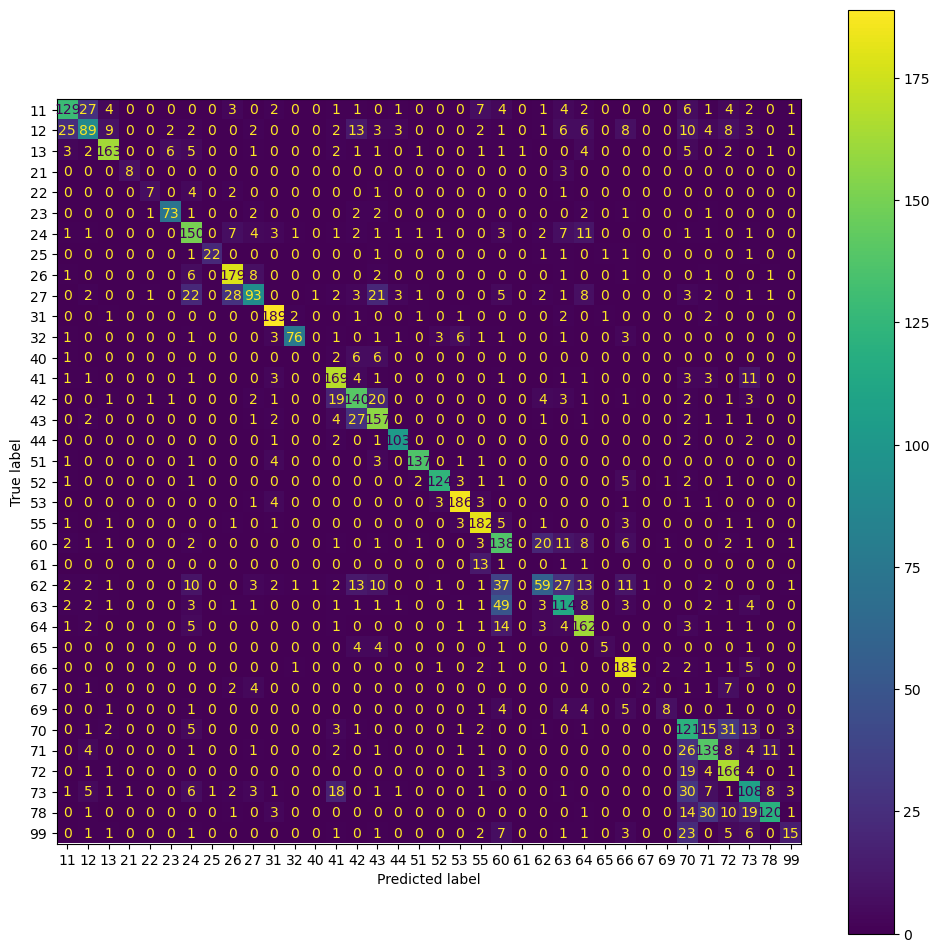

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.show();
# Diagonal shows the Predicted matches the Label from the Test data and hence predicted correctly.

In [38]:
# List of targets is needed to calculate some metrics.
target_name_list = sorted(df_sample['event'].unique().tolist())
print(target_name_list)

[11, 12, 13, 21, 22, 23, 24, 25, 26, 27, 31, 32, 40, 41, 42, 43, 44, 51, 52, 53, 55, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 78, 99]


__Accuracy Score__
Computes the accuracy, either the fraction (default) or the count (normalize=False) of correct predictions.
    
Documentation References:
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score

In [39]:
accuracy_score(y_test, y_predict) # Accuracy score is how many were predicted correctly vs. predicted incorrectly.

0.7144779850028841

In [40]:
balanced_accuracy_score(y_test, y_predict) # Deals with imbalanced datasets. Is the average recall for each class.

0.6368555047114026

In [41]:
# Comparing of these two lists can be used to see if there is any class that appears in the Training data and 
# not in the Test data and vice versa. 
# If there are any classes identified that do not occur in one of the training/test/predicted datasets 
# it is probably caused by low number of records in the class and split not accounting for such low number.

unique_train_list = sorted(y_train.unique())
unique_test_list = sorted(y_test.unique())
unique_pred_list = sorted(set(list(y_predict)))
print(f'Unique Train Classes: {unique_train_list}')
print(f'Unique Test Classes: {unique_test_list}')
print(f'Unique Predicted Classes: {unique_pred_list}')
print(f'Classes found in Training or Test data but not both: {set(unique_train_list) - set(unique_test_list)}')
print(f'Classes found in Test or Predicted but not both: {set(unique_pred_list) - set(unique_test_list)}')

Unique Train Classes: [11, 12, 13, 21, 22, 23, 24, 25, 26, 27, 31, 32, 40, 41, 42, 43, 44, 51, 52, 53, 55, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 78, 99]
Unique Test Classes: [11, 12, 13, 21, 22, 23, 24, 25, 26, 27, 31, 32, 40, 41, 42, 43, 44, 51, 52, 53, 55, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 78, 99]
Unique Predicted Classes: [11, 12, 13, 21, 22, 23, 24, 25, 26, 27, 31, 32, 40, 41, 42, 43, 44, 51, 52, 53, 55, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 78, 99]
Classes found in Training or Test data but not both: set()
Classes found in Test or Predicted but not both: set()


__Precision Score__ 
The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. __The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.__ The best value is 1 and the worst value is 0.

The average parameter has the following options: ‘micro’, ‘macro’, ‘samples’, ‘weighted’, None or the default = ’binary’. This parameter is required for multiclass/multilabel targets. If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data.

- 'binary': Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.
- 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
- 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
- 'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
- 'samples': Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

Documentation References:
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score

In [42]:
print(precision_score(y_test, y_predict, labels = target_name_list, average='micro'))

0.7144779850028841


__Recall__ The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. __The recall is intuitively the ability of the classifier to find all the positive samples.__

The best value is 1 and the worst value is 0.

Documentation References:
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

In [43]:
recall_score(y_test, y_predict, average='micro')

0.7144779850028841

__F1 Score__
F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The average parameter has the same options as the Precision above.

Documentation References:
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

In [44]:
print(f1_score(y_test, y_predict, labels = target_name_list, average='micro'))

0.7144779850028841


__Classification Report__
Provides the class model classification metrics for each class as well as for the full dataset. It also provides the number of records or data points used for testing.

In [45]:
print(classification_report(y_test, y_predict, labels = target_name_list, zero_division = 0))
# Observations:
# Classes that had a low number of records tended to have low metrics. 
# Although low metrics can also occur in the classes with the 200 records.

              precision    recall  f1-score   support

          11       0.75      0.65      0.69       200
          12       0.61      0.45      0.52       200
          13       0.87      0.81      0.84       200
          21       0.89      0.73      0.80        11
          22       0.70      0.47      0.56        15
          23       0.89      0.86      0.87        85
          24       0.66      0.75      0.70       200
          25       0.96      0.76      0.85        29
          26       0.79      0.90      0.84       200
          27       0.74      0.47      0.57       200
          31       0.86      0.94      0.90       200
          32       0.94      0.77      0.84        99
          40       0.00      0.00      0.00        15
          41       0.72      0.84      0.78       200
          42       0.64      0.70      0.67       200
          43       0.65      0.79      0.71       200
          44       0.90      0.93      0.92       111
          51       0.95    

Note on overfitting: Very high values of accuracy (~1.0) may mean that the model is overfitting and typically not considered a good result. Some of the ones that have 1.0 above are those with low number of data. These are good candidates to obtain more data as the current data may not be enough to develop a good model.

# Predicting Using the Model
[Return to Table of Contents](#Table-of-Contents)

Example narratives to use:
- The IE suffered a hairline fracture of his left fibula as he stepped over a piece of poly pipe on to rough ground during the pre-op inspection of a light duty vehicle.
- Miner was mucking out a heading with a LHD when a rock hit the hand held fire extinguisher mounted on the outside of the cab.  The fire extinguisher activated and the powder went into the miners face getting into his eyes. The miner was wearing his safety glasses.
- Operator was doing the routine end of week equipment shutdown and clean out when he got a chemical into his eye. Investigation determine there was a small drip from the line one floor higher. Employee was wearing all required PPE including safety glasses.

In [46]:
# Function to input custom narrative.
text_to_predict = pd.Series(input('Input text to predict OIICS Category (i.e., see examples in Markdown cell above): '))
# Tranform the input narrative into the BoW model vector array
X_input = vectorizer.transform(text_to_predict).toarray()
# Predicts the OIICS category given the input text vectors
y_predict_input = clf.predict(X_input)
# Probability of prediction. Because this is multiclass problem the probability can be lower than 0.5.
y_predict_input_prob = sorted(clf.predict_proba(X_input)[0], reverse = True)[0]

# Finds the predicted OIICS Category to the OIICS Event Description
OIICS_Desc_Pred = df_OIICS_Event_Code_Map.loc[df_OIICS_Event_Code_Map['OIICS_Event_Code'] == y_predict_input[0], 
                                              ['OIICS_Event_Description']].reset_index(drop = True)
# Prints the Category Number and the OIICS Event Description.
print(f"\nPredicted Text OIICS category is: {y_predict_input[0]}-{OIICS_Desc_Pred.at[0, 'OIICS_Event_Description']}")
print(f"Probability of prediction is: {y_predict_input_prob}")

Input text to predict OIICS Category (i.e., see examples in Markdown cell above):  Miner was mucking out a heading with a LHD when a rock hit the hand held fire extinguisher mounted on the outside of the cab. The fire extinguisher activated and the powder went into the miners face getting into his eyes. The miner was wearing his safety glasses.



Predicted Text OIICS category is: 31-Fires
Probability of prediction is: 0.5


In [47]:
# To review the full list of OIICS Event Description.
# Note that this is the full list and not the list that was used in the Training data split. 
#df_OIICS_Event_Code_Map

# Dimensionality Reduction
[Return to Table of Contents](#Table-of-Contents)<br>

In cases where there are many featuers in the dataset it may be wise to reduce the dimensionality. There are varios methods for reducing the dimensionality of high dimensional data. One method discussed in Lecture 11 is feature selection which reduces the features used in classification problem. Other methods include Principal Component Analysis (PCA) and T-distributed Stochastic Neighbor Embedding (TSNE). When a dataset has high number of dimensions, in some cases using a dimensionality reduction method may improve performance of a model, especially especially in unsupervised ML clustering. 

PCA and TSNE methods find a mathematical representatation of multi-dimensionsional data (i.e., higher than 3-Dimensions) and convert to n dimensions or less where n is the total number of features. In the case of text data, every token (e.g., word, combination of words, sentence, paragraph) within each record is a dimension. For both methods (i.e., PCA and TSNE) the array of the reduced dimensions for performing the prediction or clustering calculation is created. This reduces the dimensionality to lower dimensions (e.g., 2- or 3-dimensions) and in the case of NLP or text data is a projection from the full bag of words vectors array. The resulting array of the vectors can be then used for classification or clustering algorithms. Note that for NLP classification and prediction tasks you may still need to keep a relatively large number of components. For NLP clustering the performance may be acceptable with low level of components.

PCA is a linear dimensionality reduction technique that utilizes Singular Value Decomposition (SVD). The technique calculates  components (based on the data features) that explain the most variance (i.e., component 1 higher variance than component 2 which is higher than component 3 and so on depending on how many n_components were selected). For PCA there are various important parameters that will determine the extent of the dimensionality reduciton as well as mathematical model applied.
- n_components: Number of components to keep. If n_components is not set all components are kept. N_components have to be less than number of features. 
    - N_components = integer will use the n defined number of components. 
    - Other n_components values will take much longer. Using n_components 0<n<1 will selects number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components. Using n_components =  mle and svd_solver = 'auto' may take a long time to calculate.
- svd_solver: 
    - 0 < n_components < 1 and svd_solver == 'full': select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.
    - svd_solver == 'arpack': the number of components must be strictly less than the minimum of n_features and n_samples.

In both cases (PCA or TSNE), the dimensionality reduction affects the array used for training/testing the model and reduce the original array to 2 or 3 dimensions as specified in the PCA or the TSNA functions. The rest of the functions are the same. See below.

Documentation References:
- PCA Function Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- TSNE Function Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

### PCA
[Return to Table of Contents](#Table-of-Contents)

In [48]:
def PCA_function(array_to_reduce):
    global array_reduced_scaled
    # Examples: comment out the non-used PCA.
    # PCA Model with N Components (try, 2, 10, 100, 1000)
    pca = PCA(n_components = 2)

 
    array_reduced = pca.fit_transform(array_to_reduce)
    # The bow_calc_array is the reduced bow_array to be used for the calculation of clusters.

    # Projection Plot (scaled) of records in data.
    scaler = MinMaxScaler()
    scaler.fit(array_reduced)
    array_reduced_scaled = scaler.transform(array_reduced)

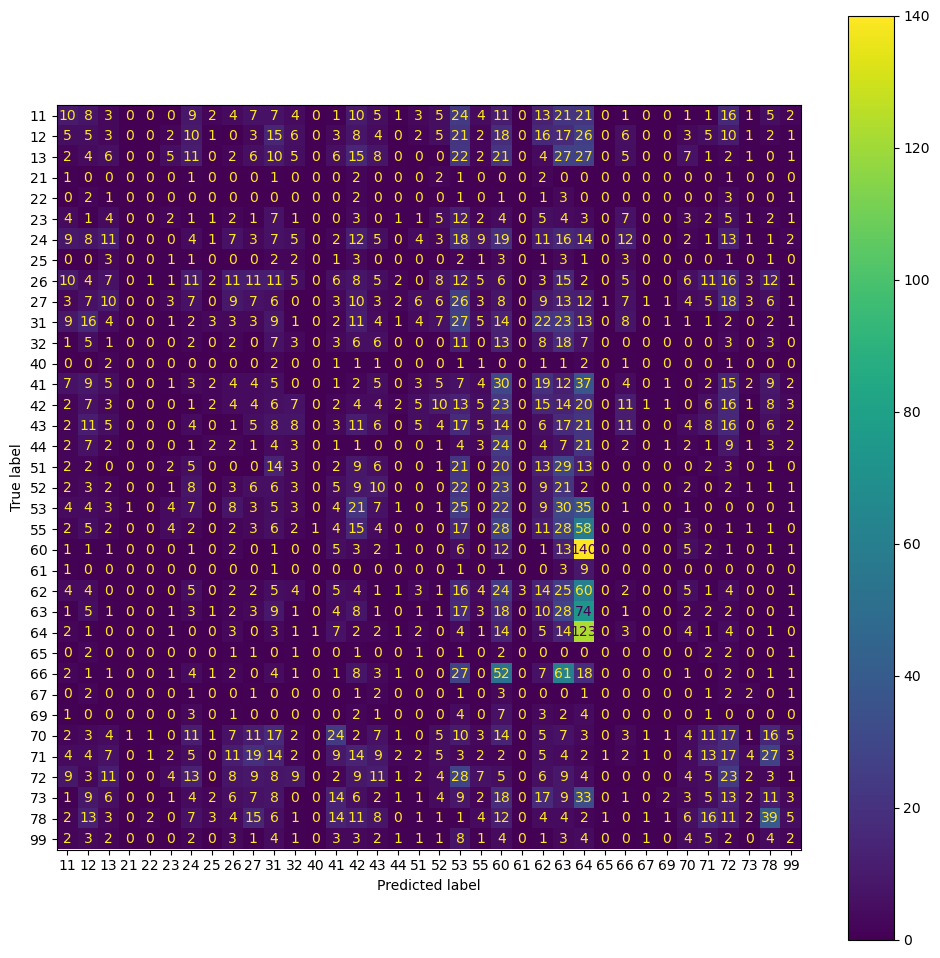

              precision    recall  f1-score   support

          11       0.09      0.05      0.06       200
          12       0.03      0.03      0.03       200
          13       0.05      0.03      0.04       200
          21       0.00      0.00      0.00        11
          22       0.00      0.00      0.00        15
          23       0.05      0.02      0.03        85
          24       0.03      0.02      0.02       200
          25       0.00      0.00      0.00        29
          26       0.09      0.06      0.07       200
          27       0.05      0.04      0.04       200
          31       0.04      0.04      0.04       200
          32       0.04      0.03      0.03        99
          40       0.00      0.00      0.00        15
          41       0.01      0.01      0.01       200
          42       0.02      0.02      0.02       200
          43       0.04      0.03      0.04       200
          44       0.00      0.00      0.00       111
          51       0.00    

In [49]:
%%time
# Dividing the sampled data into 80 for Training and 20 for testing.

x = df_sample.loc[:,'norm_text_wlemma'] # The features we want to use for predicting is the tokens from the narratives.
y = df_sample.loc[:,'event']

X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    stratify = y, # Stratified sampling attempts to balance classes.
                                                    test_size=0.2, # 80/20 for training/testing
                                                    random_state=1)

vectorizer = TfidfVectorizer(lowercase=True, 
                             analyzer='word',
                             stop_words=stopwords_custom, 
                             # Ensures I am applying the same stopwords here and in text normalization function.
                             ngram_range=(1, 2), # Considers 1-grams (i.e., single words) and 2-grams (i.e., two words) 
                             max_df = 0.95, 
                             min_df = 0.0005)

# Converts the training data to a Bag of Words Array
X_train = vectorizer.fit_transform(X_train).toarray()

# At this stage we want to reduce the array from 4000+ dimensions to a projection of 2 diemensions. 
PCA_function(array_to_reduce = X_train)
X_train = array_reduced_scaled

# Converts the testing data to the BoW Array of the Training data
X_test = vectorizer.transform(X_test).toarray()

# PCA also needs to reduce the test data to the projection of 2 diemensions. 
PCA_function(array_to_reduce = X_test)
X_test = array_reduced_scaled

# Random Forest Classifier
clf = RandomForestClassifier(max_depth = None,  class_weight = 'balanced', random_state=0) 
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)
cm = confusion_matrix(y_test, y_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.show();

print(classification_report(y_test, y_predict, labels = target_name_list, zero_division = 0))

In this case using PCA dimensionality reduction significantly decreases the performance of the model by all metrics. It looks like PCA is using the features related to OIICS Code 51 as its main feature and tends to overprecict this class.

### TSNE
[Return to Table of Contents](#Table-of-Contents)

TSNE uses a perplexity paramater.  The perplexity defines how the TSNE Plot looks and its two main dimensions. Ideally the user wants separable clusters and would iterate thru different perplexities and select the one with the most defined clusters.  In case of high variable data (e.g., different filters that could be applied), reduce dimensionality and users being SME's in other areas, it would be tough to evaluate and select a perplexity for each unique case.

Implementation of TSNE would be very similar as above except that would call TSNE in place of the PCA funciton. Note that TSNE takes much longer to calculate.

In [50]:
def TSNE_function(array_to_reduce):
    global array_reduced_scaled
    perplexity = 30
    array_reduced = TSNE(n_components=2, perplexity = perplexity, random_state=42, 
                         n_iter=5000).fit_transform(bow_array) # TSNE Model with 2 Components
    
    # Projection Plot (scaled) of records in data.
    scaler = MinMaxScaler()
    scaler.fit(array_reduced)
    array_reduced_scaled = scaler.transform(array_reduced)
    
    print(f'PLEASE WAIT: Running TSNE function is slow.  TSNE Perplexity parameter is set at {perplexity}.')

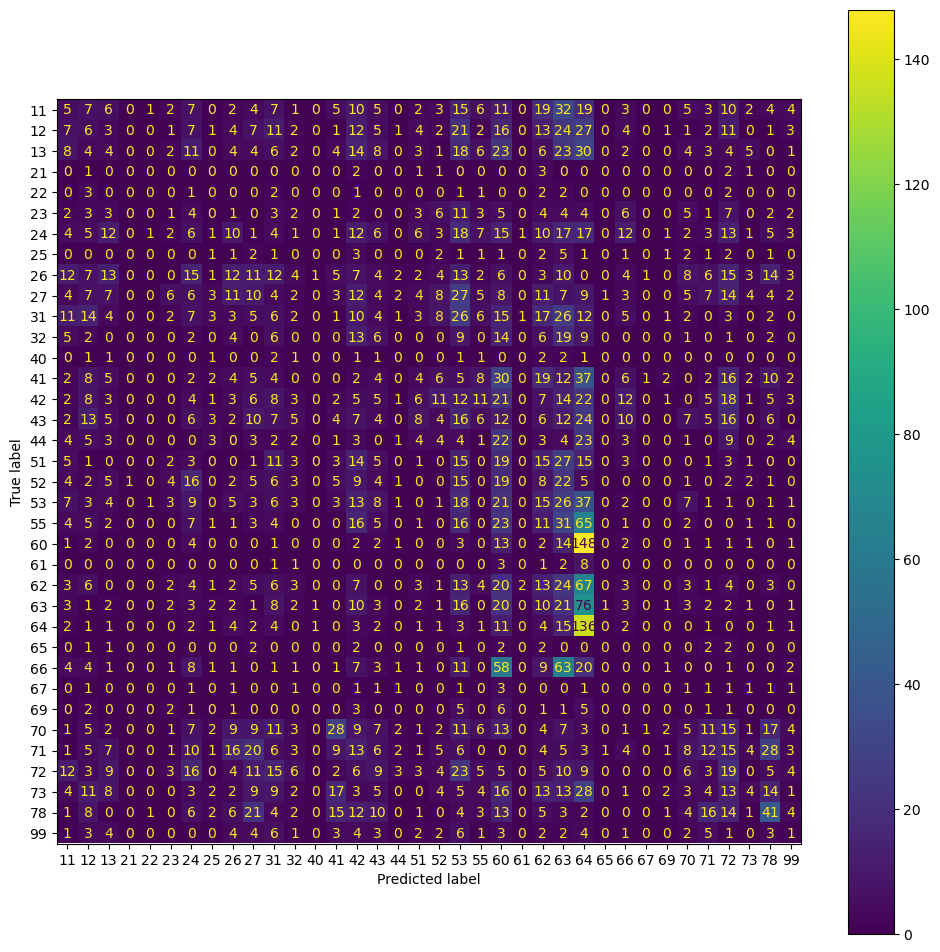

              precision    recall  f1-score   support

          11       0.04      0.03      0.03       200
          12       0.04      0.03      0.03       200
          13       0.03      0.02      0.03       200
          21       0.00      0.00      0.00        11
          22       0.00      0.00      0.00        15
          23       0.03      0.01      0.02        85
          24       0.03      0.03      0.03       200
          25       0.03      0.03      0.03        29
          26       0.10      0.06      0.07       200
          27       0.06      0.05      0.05       200
          31       0.03      0.03      0.03       200
          32       0.00      0.00      0.00        99
          40       0.00      0.00      0.00        15
          41       0.00      0.00      0.00       200
          42       0.02      0.03      0.02       200
          43       0.03      0.02      0.02       200
          44       0.05      0.01      0.02       111
          51       0.01    

In [51]:
%%time
# Dividing the sampled data into 80 for Training and 20 for testing.

x = df_sample.loc[:,'norm_text_wlemma'] # The features we want to use for predicting is the tokens from the narratives.
y = df_sample.loc[:,'event']

X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    stratify = y, # Stratified sampling attempts to balance classes.
                                                    test_size=0.2, # 80/20 for training/testing
                                                    random_state=1)

vectorizer = TfidfVectorizer(lowercase=True, 
                             analyzer='word',
                             stop_words=stopwords_custom, 
                             # Ensures I am applying the same stopwords here and in text normalization function.
                             ngram_range=(1, 2), # Considers 1-grams (i.e., single words) and 2-grams (i.e., two words) 
                             max_df = 0.95, 
                             min_df = 0.0005)

# Converts the training data to a Bag of Words Array
X_train = vectorizer.fit_transform(X_train).toarray()

# At this stage we want to reduce the array from 4000+ dimensions to a projection of 2 diemensions. 
PCA_function(array_to_reduce = X_train)
X_train = array_reduced_scaled

# Converts the testing data to the BoW Array of the Training data
X_test = vectorizer.transform(X_test).toarray()

# PCA also needs to reduce the test data to the projection of 2 diemensions. 
PCA_function(array_to_reduce = X_test)
X_test = array_reduced_scaled

# Random Forest Classifier
clf = RandomForestClassifier(max_depth = None,  class_weight = 'balanced', random_state=0) 
clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)
cm = confusion_matrix(y_test, y_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
plt.show();

print(classification_report(y_test, y_predict, labels = target_name_list, zero_division = 0))

# NOTEBOOK END